** $Board\ Game\ Database\ from\ Board\ GameGeek$**

# $General\ Overview$

### Dataset

* Data was taken from Kaggle - https://www.kaggle.com/threnjen/board-games-database-from-boardgamegeek?select=user_ratings.csv
* This dataset Feature-rich multi-table dataset full of interesting information about Board Games which can be used for tasks such as exploratory EDA, predictive modeling, or recommender systems.


### Project Modules & Packages

In [ ]:
!pip install FuzzyWuzzy
!pip install surprise

     |████████████████████████████████| 11.8 MB 3.8 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630205 sha256=9bc94b79e7a8c13bc697cdd29a03054bc9d810e8dc748eba17d5d1a3f62724b0
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score ,f1_score ,roc_auc_score ,log_loss
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV ,StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')
%matplotlib inline

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process 

from scipy.spatial import distance

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split as sup_tt_split

Kaggke API
**remember to upload kaggke json credatinatials

In [ ]:
!pip install -q kaggle

In [ ]:
#upload file and then --> 
#create kaggle folder
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#copy json file to kaggle folder
! cp kaggle.json ~/.kaggle/

In [ ]:
#dowload board game zip file
!kaggle datasets download -d datasets/paultimothymooney/chest-xray-pneumonia

board-games-database-from-boardgamegeek.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#unzip dataset files
!unzip /content/board-games-database-from-boardgamegeek.zip

Archive:  /content/board-games-database-from-boardgamegeek.zip
  inflating: artists_reduced.csv     
  inflating: bgg_data_documentation.txt  
  inflating: designers_reduced.csv   
  inflating: games.csv               
  inflating: mechanics.csv           
  inflating: publishers_reduced.csv  
  inflating: ratings_distribution.csv  
  inflating: subcategories.csv       
  inflating: themes.csv              
  inflating: user_ratings.csv        


In [ ]:
#set max columns to 
pd.set_option('display.max_columns', 20 )
pd.set_option('display.max_rows' , 40)
pd.options.display.max_rows

40

### Load CSV file to Pandas DataFrame

In [ ]:
#read csv's
games = pd.read_csv('/content/games.csv')
mechanics = pd.read_csv('/content/mechanics.csv')
themes = pd.read_csv('/content/themes.csv')
subcategories = pd.read_csv('/content/subcategories.csv')
rank_dist = pd.read_csv('/content/ratings_distribution.csv')
user_rank = pd.read_csv('/content/user_ratings.csv')
#games.head()

In [ ]:
games.head(3)

,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,...,Rank:partygames,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens
0,1,Die Macher,die macher game seven sequential political rac...,1986,4.3206,7.61428,7.10363,1.57979,3,5,...,21926,21926,0,1,0,0,0,0,0,0
1,2,Dragonmaster,dragonmaster tricktaking card game base old ga...,1981,1.9630,6.64537,5.78447,1.45440,3,4,...,21926,21926,0,1,0,0,0,0,0,0
2,3,Samurai,samurai set medieval japan player compete gain...,1998,2.4859,7.45601,7.23994,1.18227,2,4,...,21926,21926,0,1,0,0,0,0,0,0


Merge df

In [ ]:
features = games = pd.read_csv('games.csv')
features = pd.concat( [features.BGGId , features.iloc[:,-8:-1] ] ,axis =1 )
features = features.merge(subcategories, how="left" ,left_on = 'BGGId' ,right_on= 'BGGId',  suffixes=("_left", "_right"))
features = features.merge(themes, how="left" ,left_on = 'BGGId' ,right_on= 'BGGId',  suffixes=("_left", "_right"))
features = features.merge( mechanics , how="left" ,left_on = 'BGGId' ,right_on= 'BGGId',  suffixes=("_left", "_right"))
features.shape

(21925, 392)

# Most Popular Games

In [ ]:
# bringing most pop games for new users 
games_pop = games.copy()
games_pop['game_popularty'] = games_pop['AvgRating'] /10 * games_pop['NumOwned']
top_ten_pop_games = games_pop.sort_values(by='game_popularty',ascending = False).head(10)
top_ten_pop_games = top_ten_pop_games[['BGGId','Name','Description','ImagePath']]
top_ten_pop_games = top_ten_pop_games.reset_index(drop = True) 
top_ten_pop_games

,BGGId,Name,Description,ImagePath
0,30549,Pandemic,pandemic virulent disease break simultaneously...,https://cf.geekdo-images.com/S3ybV1LAp-8SnHIXL...
1,822,Carcassonne,carcassonne tileplacement game player draw pla...,https://cf.geekdo-images.com/okM0dq_bEXnbyQTOv...
2,13,Catan,catan settler catan player try dominant force ...,https://cf.geekdo-images.com/W3Bsga_uLP9kO91gZ...
3,68448,7 Wonders,leader great city ancient world gather resou...,https://cf.geekdo-images.com/RvFVTEpnbb4NM7k0I...
4,178900,Codenames,codename easy party game solve puzzle game div...,https://cf.geekdo-images.com/F_KDEu0GjdClml8N7...
5,173346,7 Wonders Duel,way wonder duel resemble parent game wonde...,https://cf.geekdo-images.com/WzNs1mA_o22ZWTR8f...
6,167791,Terraforming Mars,s mankind begin terraform planet mar giant cor...,https://cf.geekdo-images.com/wg9oOLcsKvDesSUdZ...
7,36218,Dominion,quotyou monarch like parent ruler small pleasa...,https://cf.geekdo-images.com/j6iQpZ4XkemZP07HN...
8,9209,Ticket to Ride,elegantly simple gameplay ticket ride learn ...,https://cf.geekdo-images.com/ZWJg0dCdrWHxVnc0e...
9,230802,Azul,introduce moor azulejos originally white blue ...,https://cf.geekdo-images.com/tz19PfklMdAdjxV9W...


# Collaborative filtering - Rate by User Ratings

In [ ]:
#number of users in user ratings
user_rank.Username.nunique()

411374

In [ ]:
#choose user to suggest to
active_user_id = 'zzzvone' 
active_user_ratings = user_rank[user_rank['Username'] == active_user_id]

print(active_user_ratings.shape)
active_user_ratings.head()

In [ ]:
#get active_user_games and users that played same games as the active user
active_user_games = active_user_ratings['BGGId']
common_ratings = user_rank[user_rank['BGGId'].isin(active_user_games)]

print(f"Number of users that have at least one game in common with the active \
user: {common_ratings.Username.nunique()} users")

print(common_ratings.shape)
common_ratings.sample(5)

In [ ]:
#filter users that have rated at least 'min_common_items'(15) from 'active user' games
min_common_items = 15
potential_neighbors = common_ratings.groupby('Username').filter(lambda grp: len(grp) >= min_common_items)

print(f"{potential_neighbors.Username.nunique()} users")

print(potential_neighbors.shape)
potential_neighbors.sample(5)

1467 users
(23409, 3)


,BGGId,Rating,Username
862022,822,5.0,Corwyn59
12617488,555,10.0,akapastorguy
8670094,9217,8.0,liefde_is
6047487,42,8.2,zefquaavius
8745375,42,9.0,mothertruckin


In [ ]:
#remove 'active_user_id' from potential_neighbors
print(potential_neighbors.shape)
potential_neighbors = potential_neighbors.loc[potential_neighbors.Username != active_user_id]
print(potential_neighbors.shape)

(23409, 3)
(23388, 3)


In [ ]:
### view neighbor for example and compare to 'active user ratings'
# neighbor_id = 'Thesp'

# neighbor_ratings = potential_neighbors.loc[potential_neighbors.Username == neighbor_id, :]

# print(neighbor_ratings.shape)
# neighbor_ratings

# negihbor_ratings_compare = neighbor_ratings.merge(active_user_ratings, on='BGGId', how='inner', suffixes=('_neighbor', '_active'))
# negihbor_ratings_compare

In [ ]:
#take neighbor_ratings df return similarity score
def calc_similarity(neighbor_ratings , active_user_ratings):
    negihbor_ratings_compare = neighbor_ratings.merge(active_user_ratings,
         on='BGGId', how='inner', suffixes=('_neighbor', '_active'))
    
    cos_distance = distance.cosine(negihbor_ratings_compare['Rating_active'],
                                   negihbor_ratings_compare['Rating_neighbor'])
    return 1 - cos_distance

In [ ]:
#Apply calc_similarity function on user in 'potential_neighbors'
similarities = potential_neighbors.groupby('Username').apply(calc_similarity ,(active_user_ratings) )
similarities.name = 'Similarity'
similarities.shape 

In [ ]:
# get active user neighbors where min_similarity_score > X
min_similarity_score = 0.96
relevant_neighbors = similarities[similarities > min_similarity_score].index

print(len(relevant_neighbors))
relevant_neighbors

896


Index(['-mIDE-', '1000games', '1000rpm', '1nf1n1ty', '2ndPlace', '5th Beatles',
       'Abundance of Flowers', 'Ajax', 'AlPacino11', 'Alan How',
       ...
       'yid0', 'yolandavi', 'yvesvanherp', 'yzemaze', 'zefquaavius', 'zinv',
       'zizishaoye', 'zodiak', 'zumikon', 'zuzusdad'],
      dtype='object', name='Username', length=896)

In [ ]:
#get games suggestion where relevant_neighbors rate the game 
    #and the active user did NOT rate the game
recommend_ratings = user_rank.loc[user_rank['Username'].isin(relevant_neighbors) &   # only games that were rated by the active user neighbors
                                   ~user_rank['BGGId'].isin(active_user_games)]  # only games that the active user did not see

print(recommend_ratings.shape)
recommend_ratings.head()

In [ ]:
# filter 'recommend_ratings' where number of ratings by 
# the relevant neighbors on a specifc game > 'min_neighbors_ratings' (7) 
# (without the active user) 

#why ? - in order to later get a valid Weighted average score
min_neighbors_ratings = 7

print(recommend_ratings.shape)
recommend_ratings = recommend_ratings.groupby('BGGId').filter(
    lambda grp: len(grp) > min_neighbors_ratings)
print(recommend_ratings.shape)
recommend_ratings.BGGId.nunique()
recommend_ratings.info()

(723426, 3)
(692212, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 692212 entries, 178 to 18942201
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   BGGId     692212 non-null  int64  
 1   Rating    692212 non-null  float64
 2   Username  692212 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 21.1+ MB


In [ ]:
def calc_game_score(game_ratings):
    game_ratings = game_ratings.join(similarities, on='Username')
    return (game_ratings['Rating'] * 
            game_ratings['Similarity']).sum() / \
            game_ratings['Similarity'].sum()

In [ ]:
game_scores = recommend_ratings.groupby('BGGId').apply(calc_game_score)
game_scores.name = 'Score'
game_scores.head()

BGGId
1    7.603424
2    6.335382
3    7.388719
4    6.664427
5    7.421158
Name: Score, dtype: float64

In [ ]:
#Calc game rating weighted avg (with similarity)
def calc_game_score(game_ratings , similarities):
    game_ratings = game_ratings.join(similarities, on='Username')
    return (game_ratings['Rating'] * 
            game_ratings['Similarity']).sum() / \
            game_ratings['Similarity'].sum()

In [ ]:
# apply calc_game_score on recommend_ratings
game_scores = recommend_ratings.groupby('BGGId').apply(calc_game_score ,(similarities) )
game_scores.name = 'Score'
game_scores.head()

BGGId
1    7.603424
2    6.335382
3    7.388719
4    6.664427
5    7.421158
Name: Score, dtype: float64

In [ ]:
# ### example weighted avg rating score
# example = recommend_ratings[recommend_ratings.BGGId == 40819]
# example = example.join(similarities, on='Username')
#print(game_scores[40819])
# example

In [ ]:
#select top 5 games suggestion by game score (rating weighted avg)
n_recommendations = 5
final_recommendation = game_scores.sort_values(ascending=False)[:n_recommendations]
final_recommendation= final_recommendation.to_frame('score').reset_index()
final_recommendation

,BGGId,score
0,342942,9.374807
1,299659,9.021343
2,324856,8.962538
3,108687,8.797722
4,253607,8.789675


In [ ]:
#merge top 5 games suggestion with game details
top_picks= final_recommendation.merge( games[['BGGId','Name','Description']] , on='BGGId', how='left')
top_picks

,BGGId,score,Name,Description
0,342942,9.374807,Ark Nova,ark nova plan design modern scientifically man...
1,299659,9.021343,Clash of Cultures: Monumental Edition,clash culture monumental edition bring classic...
2,324856,8.962538,The Crew: Mission Deep Sea,tricktaking card game crew mission deep sea pl...
3,108687,8.797722,Puerto Rico,deluxe game puerto rico begin puerto rico anni...
4,253607,8.789675,1822CA,xx game cover canada coast coast reimplement ...


# Game Recommendation -  Content Based

Check Feature usage

In [ ]:
#are there features that are not in use ? -- no
test = features.iloc[: ,1:]
sum_row = test.sum(axis = 0)
print(sum_row[sum_row == 0])

#are there agmes where all features are 0 ? --> 136 games
test = features.iloc[: ,1:]
sum_row = test.sum(axis = 1)
sum_row[sum_row == 0].count()

Series([], dtype: int64)


136

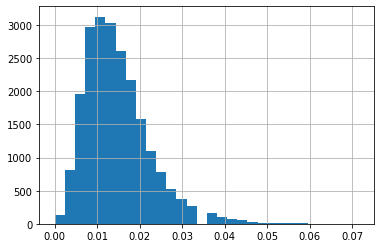

In [ ]:
#game feature propotion - the precentage of marked features in every game
features.iloc[:,1:].mean(axis = 1).hist(bins = 30)

In [ ]:
#convert to sparse matrix element
features_sparse = csr_matrix(features.iloc[:,1:].values) #BGGId left out

Model Object

In [ ]:
#define knn model parameters
model_knn = NearestNeighbors(metric= 'cosine' , algorithm= 'brute' , n_neighbors= 11 )
model_knn

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=11)

In [ ]:
#fit the model
model_knn.fit(features_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=11)

##Get Recommendation by giving game name

Get Game Name

In [ ]:
#try to suggest exact names
#enter_game_name = 'catan'
enter_game_name = input('Please enter board game name :')
games_name_suggest = process.extract(enter_game_name , games.Name , limit = 10)
print(f'Chose game from the list:')
for game in games_name_suggest:
    print(game[0])
enter_game_name = input('chosen game is :')

Please enter board game name :catan
Chose game from the list:
Catan
Catan Card Game
The Starfarers of Catan
Starship Catan
Catan: Portable Edition
The Kids of Catan
CATAN 3D Collector's Edition
Settlers of Catan: Rockman Edition
Simply Catan
Catan Histories: Struggle for Rome
chosen game is :catan


In [ ]:
exact_name , score , idx = process.extractOne( enter_game_name , games.Name )
print(f' found the game : "{exact_name}"  in row : {idx}, match score is : {score} ')

 found the game : "Catan"  in row : 12, match score is : 100 


Get Game Features by given game name

In [ ]:
#selected_game_id = 1
selected_game_id = games.iloc[idx ,0]

selected_game_index = games.BGGId[games.BGGId == selected_game_id].index
#create index value for idx
#selected_game_index = pd.Int64Index(data = [idx] , dtype = 'int64')

In [ ]:
select_game_features = features.iloc[selected_game_index , 1:]

Calculate Distances

In [ ]:
distances, indices  = model_knn.kneighbors(select_game_features)

In [ ]:
#distances is 2D , convert to 1D and take all elemnts except first value(self = 1)
coff = 1- distances.round(5)[0][1:]

In [ ]:
#limit top 10 indices without the choosen game 
indices = indices[0][1:11]

In [ ]:
#get relevant data of k neighbors
filter = ~games.BGGId.isin( [selected_game_id]) #without the game selected
suggested_games = games.iloc[indices ,0:6][filter == True]
suggested_games['User_relvant_score'] =  suggested_games.AvgRating * coff
suggested_games['distance'] = 1- coff
suggested_games

,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,User_relvant_score,distance
21183,305668,Catan: 25th Anniversary Edition,catan th anniversary edition contain catan bas...,2020,2.3333,7.94269,7.306242,0.08013
20921,298278,Catan: 25 Jahre Jubiläums-Edition,catan jahre jubilaumlumsedition special edit...,2020,0.0000,7.68939,6.744056,0.12294
21837,338697,CATAN: 3D Edition,catan player try dominant force island catan b...,2021,2.0000,7.52962,6.603929,0.12294
12906,148949,Istanbul,s hustle bustle istanbul grand bazaar merchant...,2014,2.5857,7.57049,4.848975,0.35949
11271,117985,Star Trek: Catan,settle final frontiersince million star trek...,2012,2.3701,7.00475,4.300496,0.38606
2614,3972,Catan: Portable Edition,settler catan travel edition say travel editio...,2002,2.2517,6.74896,4.143457,0.38606
10863,103091,Catan Histories: Merchants of Europe,late middle age trade flourish europe economic...,2011,2.4524,6.64861,3.911710,0.41165
8724,38749,Catan Geographies: Germany,germany found reunite year germanys th b...,2008,2.3684,6.84421,4.026791,0.41165
13660,161527,Catan: Ancient Egypt,catan ancient egypt designer klaus teuber tran...,2014,2.4737,7.26921,4.115391,0.43386
12773,147240,Catan: Family Edition,new edition ldquosettler catan ndash board gam...,2012,2.2857,6.61849,3.746992,0.43386


##Get Recommendation by User's Top 3 Rated Games

In [ ]:
#user = input('Enter your User Name :')
user = 'Tonydorrf'
#get x highest game ratings of choosen user
x = 3
highest_rank = user_rank[user_rank.Username == user].sort_values(by = 'Rating' , ascending = False).iloc[:x , 0]
#get highest_rank features
highest_rank_features = features[features.BGGId.isin(highest_rank)].iloc[:,1:]

In [ ]:
games_played = user_rank.BGGId[user_rank.Username == user]
filter = ~games.BGGId.isin( games_played) #without the games the user played

check common_features

In [ ]:
#check how many common  features all x games have
#get all columns where the value is greater than 0
col_filter = highest_rank_features.sum(axis = 0) > 0
common_features = highest_rank_features.loc[:,col_filter].columns #only 3 features exsits in at least 2 games
common_features.shape

(23,)

In [ ]:
#option 2 top x features
#highest_rank_features.sum(axis = 0).sort_values(ascending = False)[:30]

In [ ]:
#Avg on highest_rank features
highest_rank_features = highest_rank_features.mean(axis = 0).rename('mean').to_frame().T
#col_filter -limit the number of features to the common ones
highest_rank_features = highest_rank_features.loc[:,common_features]

In [ ]:
features[filter == True].loc[:, common_features ]

Calculate NN

In [ ]:
#convert to sparse matrix element
features_sparse = csr_matrix( features[filter == True].loc[:, common_features ] ) #filter out games played + inculde only common_features col

In [ ]:
#define knn model parameters
model_knn_ug = NearestNeighbors(metric= 'cosine' , algorithm= 'brute' , n_neighbors= 11 )
#fit the model
model_knn_ug.fit(features_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=11)

In [ ]:
distances, indices  = model_knn_ug.kneighbors(highest_rank_features)

In [ ]:
distances

array([[0.2564776 , 0.2704628 , 0.27217466, 0.27217466, 0.27217466,
        0.27217466, 0.27217466, 0.27217466, 0.27217466, 0.27217466,
        0.27217466]])

In [ ]:
#distances is 2D , convert to 1D and take first 10 elements
coff = 1- distances.round(5)[0][0:10]
coff

array([0.74352, 0.72954, 0.72783, 0.72783, 0.72783, 0.72783, 0.72783,
       0.72783, 0.72783, 0.72783])

In [ ]:
#limit top 10 indices without the choosen game 
indices = indices[0][0:10]
indices

array([16223, 17077, 15846, 10891, 16457, 18633, 13321,  9674, 14088,
       10643])

In [ ]:
#get relevant data of k neighbors
suggested_games = games.iloc[indices ,0:6]#[filter == True]
suggested_games['User_relvant_score'] =  suggested_games.AvgRating * coff
suggested_games['distance'] = 1- coff
suggested_games

,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,User_relvant_score,distance
16223,202674,Ore City,user summary ore machi carry english title ore...,2015,2.0000,6.20846,4.616114,0.25648
17077,219208,Poison,description publisherpoison trick take card ga...,2017,0.0000,6.63947,4.843759,0.27046
15846,195180,Universal Rule,deep pocket universe balance power shift seven...,2017,2.4000,6.81134,4.957498,0.27217
10891,103745,Plethora,aim nobility point gamersquos end player buy n...,2012,2.7500,6.13750,4.467057,0.27217
16457,206463,Gads Hill 1874,description publisherthe city gads hill found ...,2016,2.5000,6.62406,4.821190,0.27217
18633,248366,Brutality,brutality pvp medieval combat brawler board ga...,2019,2.2500,7.17922,5.225252,0.27217
13321,155912,Monopoly: Marvel Comics Collectors Edition,monopoly greek mono munuomicronsigmaf single ...,2012,1.0000,5.25744,3.826523,0.27217
9674,65197,Le Marché de Samarkand,le marcheacute de samarkand game dutch bid bid...,2010,2.0000,5.26485,3.831916,0.27217
14088,168436,Pièces MontéeS,piegravece monteacutee minute card game ...,2014,2.5000,6.08085,4.425825,0.27217
10643,96157,No Retreat 2: The Africa Front 1940-1942,african deluxe series follow success retrea...,2011,2.7143,7.40833,5.392005,0.27217


###Check 'suggested games' Relvance

In [ ]:
#filter_ = features[common_features].sum(axis = 1) == 3
#filter rows where avg usage in 'common_features' is greater than 30%
filter_ = features[common_features].mean(axis = 1) > 0.1
lis_check = features.loc[:,features.columns.isin(common_features)][filter_]

In [ ]:
#get suggested_games with common_features columns
games_check = features.loc[suggested_games.index , common_features ] #features.columns.isin(common_features)
#games_check.join(games , how= 'inner')
#filter
#games_check.loc[:,features.columns.isin(common_features)]#[filter_]

lis_check.join( games_check,how = 'inner' , lsuffix = '_left' , rsuffix = '_r')

,Cat:Thematic_left,Cat:Strategy_left,Exploration_left,Adventure_left,Fantasy_left,Fighting_left,Environmental_left,Medical_left,Movies / TV / Radio theme_left,Comic Book / Strip_left,...,Set Collection_r,Action Points_r,Point to Point Movement_r,Trading_r,Push Your Luck_r,Roll / Spin and Move_r,Variable Player Powers_r,Cooperative Game_r,Pick-up and Deliver_r,Legacy Game_r
13321,0,0,0,0,0,0,0,0,1,1,...,1,0,0,1,0,1,0,0,0,0
18633,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#check common features with games played 
#games_palyed & filter_ = games with common features
games[ games.BGGId.isin(games_played) & filter_ ==True ].shape

(11, 48)

#Surprise Package - Collaborative Filtering

In [ ]:
#filter users that have rated between 10 to 200 games
user_rank_filtered = user_rank.groupby('Username').filter(lambda grp: len(grp) <= 200 and len(grp) >= 10 )
print(user_rank_filtered.shape)
user_rank_filtered.head(1)

(10290780, 3)


,BGGId,Rating,Username
1,213788,8.0,tachyon14k


##Define Functions for Results 

In [ ]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0


In [ ]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

## Specif User Sample - BaselineOnly Algorithm

In [ ]:
#choose user to suggest to
active_user_id = 'zzzvone' 
active_user_ratings = user_rank[user_rank['Username'] == active_user_id]

#get active_user_games and users that played same games as the active user
active_user_games = active_user_ratings['BGGId']
common_ratings = user_rank[user_rank['BGGId'].isin(active_user_games)]

#filter users that have rated at least 'min_common_items'(15) from 'active user' games
min_common_items = 15
reduce_rating = common_ratings.groupby('Username').filter(lambda grp: len(grp) >= min_common_items)

In [ ]:
#surprise reader object
reader = Reader(rating_scale=(0, 10))
#data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)
data = Dataset.load_from_df(reduce_rating[['Username', 'BGGId' , 'Rating']], reader) 
data

In [ ]:
#define algorithm params and get cross_validate scores
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'fit_time': (0.03036642074584961, 0.02943277359008789, 0.03616070747375488),
 'test_rmse': array([1.21992954, 1.21813962, 1.2476294 ]),
 'test_time': (0.045873165130615234, 0.0515742301940918, 0.04767608642578125)}

In [ ]:
#rain ,test split
trainset, testset = sup_tt_split( data, test_size=0.25)
#define algorithm
algo = BaselineOnly(bsl_options=bsl_options)
#fit - predict
predictions = algo.fit(trainset).test(testset)
#RMSE of predictions
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 1.2095


1.2095268940178885

In [ ]:
trainset = algo.trainset
print(algo.__class__.__name__)

BaselineOnly


In [ ]:
#add columns to predictions df - # of items ratigs , # of user ratings ,error diff
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu_item_freq'] = df.uid.apply(get_Iu)
df['Ui_user_freq'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [ ]:
df.head()

,uid,iid,rui,est,details,Iu_item_freq,Ui_user_freq,err
0,Qhorin,181,2.0,4.887673,{'was_impossible': False},9,901,2.887673
1,per42,963,6.6,6.227431,{'was_impossible': False},13,277,0.372569
2,tmccorry,6249,7.0,7.156688,{'was_impossible': False},10,1093,0.156688
3,Sorp222,42,8.0,7.561863,{'was_impossible': False},9,1111,0.438137
4,arsior,13,6.0,7.097391,{'was_impossible': False},10,1106,1.097391


In [ ]:
# bringin the worst and best predictions
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [ ]:
best_predictions

,uid,iid,rui,est,details,Iu_item_freq,Ui_user_freq,err
3744,ZargonDDG,9209,7.0,7.000756,{'was_impossible': False},11,1076,0.000756
4915,ct5150,822,7.5,7.500870,{'was_impossible': False},7,1112,0.000870
2085,Timon of Athens,822,7.0,6.998921,{'was_impossible': False},11,1112,0.001079
4647,squaredeh,3076,8.0,7.998839,{'was_impossible': False},16,1140,0.001161
4304,marclar,14996,7.5,7.498430,{'was_impossible': False},12,1021,0.001570
4843,Jimzik,822,7.0,7.001826,{'was_impossible': False},10,1112,0.001826
2750,RedwoodCroft,478,7.0,6.997709,{'was_impossible': False},15,1051,0.002291
896,saxisto,2223,5.0,5.002772,{'was_impossible': False},15,812,0.002772
5443,SiddGames,20100,7.0,7.003095,{'was_impossible': False},12,727,0.003095
967,Apparatus,14996,7.0,7.003293,{'was_impossible': False},14,1021,0.003293


In [ ]:
worst_predictions

,uid,iid,rui,est,details,Iu_item_freq,Ui_user_freq,err
215,Zuxi,13,3.0,7.273410,{'was_impossible': False},9,1106,4.273410
193,ctalbot,555,3.0,7.409428,{'was_impossible': False},11,1056,4.409428
1199,OGRussHood,555,4.0,8.423928,{'was_impossible': False},14,1056,4.423928
864,Unitoch,3076,3.0,7.498857,{'was_impossible': False},11,1140,4.498857
499,johnweldy,3076,3.0,7.590568,{'was_impossible': False},10,1140,4.590568
3842,jeffwolfe,3076,3.0,7.680994,{'was_impossible': False},12,1140,4.680994
1250,cggritt,3201,2.0,6.697347,{'was_impossible': False},11,706,4.697347
1787,MikEvaD,42,3.0,7.779458,{'was_impossible': False},11,1111,4.779458
3505,ryang,42,3.0,8.140296,{'was_impossible': False},9,1111,5.140296
4709,gamezendo.com,555,2.0,7.640432,{'was_impossible': False},9,1056,5.640432


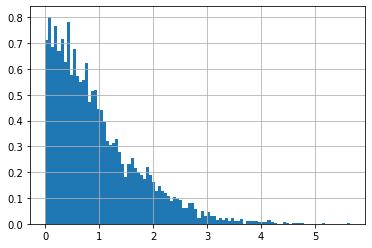

In [ ]:
#distribution of error
df.err.sort_values().hist( bins = 100, density = True)

In [ ]:
# using top N fanction to pick for  user
top_n = get_top_n(predictions, n= 10)

In [ ]:
# gatting the game in to a list 
result = top_n[active_user_id]
game_id , rating = zip(*result)

tuple

In [ ]:
#bringing top games info 
top_games = games[games['BGGId'].isin(game_id)]
# format t opgames info  
top_games = top_games[['BGGId','Name','Description','ImagePath']]

,BGGId,Name,Description,ImagePath
471,555,The Princes of Florence,player attract artist scholar try prestigious ...,https://cf.geekdo-images.com/yshiqrUPxndthguBg...


##Random Sample Find Best Algorithm

In [ ]:
#take a sample of 1000 users 
sample_users = pd.Series(user_rank_filtered['Username'].unique()).sample(2000) #user_rank_filtered['Username'].unique()[:2000]
sample_users = user_rank_filtered[user_rank_filtered.Username.isin(sample_users)]
sample_users.shape

(100448, 3)

In [ ]:
#surprise reader object
reader = Reader(rating_scale=(0, 10))
#data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)
data = Dataset.load_from_df(sample_users[['Username', 'BGGId' , 'Rating']], reader) 
data

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [ NMF() ,SlopeOne(),  CoClustering() ,NormalPredictor(), KNNWithMeans(), KNNWithZScore(), SVD(), SVDpp(), KNNBaseline(), KNNBasic(), BaselineOnly()]: #
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False ,return_train_measures = True)
    print(results)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

{'test_rmse': array([2.02176539, 2.04041918, 2.02884866]), 'train_rmse': array([1.66887088, 1.69931807, 1.68416115]), 'fit_time': (12.68483018875122, 6.516196012496948, 6.771652936935425), 'test_time': (0.34360456466674805, 0.26894712448120117, 0.3974795341491699)}
{'test_rmse': array([1.3621873 , 1.36257104, 1.35371543]), 'train_rmse': array([0.59344905, 0.59191602, 0.59352888]), 'fit_time': (5.388448238372803, 4.141262769699097, 4.325587272644043), 'test_time': (2.1570143699645996, 2.0634734630584717, 2.018275737762451)}
{'test_rmse': array([1.37047038, 1.38659105, 1.3892995 ]), 'train_rmse': array([1.10092784, 1.09391458, 1.09981679]), 'fit_time': (3.0893959999084473, 2.8106207847595215, 2.869973659515381), 'test_time': (0.24281001091003418, 0.4152190685272217, 0.23726320266723633)}
{'test_rmse': array([2.10433842, 2.11215432, 2.08368088]), 'train_rmse': array([2.09492642, 2.10810324, 2.10344028]), 'fit_time': (0.12222933769226074, 0.16026759147644043, 0.16721606254577637), 'test_ti

In [ ]:
#surprise_results
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results['dif_train_test'] = surprise_results.test_rmse - surprise_results.train_rmse
surprise_results

,test_rmse,train_rmse,fit_time,test_time,dif_train_test
Algorithm,,,,,
BaselineOnly,1.261646,1.189816,0.473379,0.309236,0.071830
SVD,1.267369,0.832434,4.492361,0.382042,0.434935
SVDpp,1.268089,0.850982,56.430831,3.959032,0.417107
KNNBaseline,1.290755,0.658146,1.006640,5.242448,0.632609
KNNWithZScore,1.352014,0.722882,0.649531,4.645119,0.629132
KNNWithMeans,1.355440,0.735555,0.553377,4.571908,0.619885
SlopeOne,1.359491,0.592965,4.618433,2.079588,0.766527
CoClustering,1.382120,1.098220,2.923330,0.298431,0.283901
KNNBasic,1.400326,0.669040,0.481032,4.429424,0.731287


In [ ]:
#take all data - user_rank_filtered
data = Dataset.load_from_df(user_rank_filtered[['Username', 'BGGId' , 'Rating']], reader) 
data

In [ ]:
#take the model with the min test rmse
surprise_results.loc[surprise_results.test_rmse.idxmin()]

test_rmse         1.261646
train_rmse        1.189816
fit_time          0.473379
test_time         0.309236
dif_train_test    0.071830
Name: BaselineOnly, dtype: float64

In [ ]:
#define algorithm params and get cross_validate scores
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'fit_time': (41.726158142089844, 54.0863778591156, 57.75129175186157),
 'test_rmse': array([1.17482708, 1.17435809, 1.17468551]),
 'test_time': (60.001829624176025, 60.860700607299805, 64.29945278167725)}

In [ ]:
#rain ,test split
trainset, testset = sup_tt_split( data, test_size=0.25)
#define algorithm
algo = BaselineOnly(bsl_options=bsl_options)
#fit - predict
predictions = algo.fit(trainset).test(testset)
#RMSE of predictions
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 1.1717


1.1716735792690818

In [ ]:
trainset = algo.trainset
print(algo.__class__.__name__)

BaselineOnly


In [ ]:
#add columns to predictions df - # of items ratigs , # of user ratings
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu_item_freq'] = df.uid.apply(get_Iu)
df['Ui_user_freq'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [ ]:
# bringin the worst and best predictions
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [ ]:
best_predictions

,uid,iid,rui,est,details,Iu_item_freq,Ui_user_freq,err
1369666,FISTofZUK,169786,10.0,10.0,{'was_impossible': False},134,34405,0.0
315539,Konieg,222509,10.0,10.0,{'was_impossible': False},62,2672,0.0
2533786,burza95,233078,10.0,10.0,{'was_impossible': False},12,7885,0.0
2496132,CarsoFergo,167791,10.0,10.0,{'was_impossible': False},43,38912,0.0
708440,mcuetov,115746,10.0,10.0,{'was_impossible': False},136,7723,0.0
708095,Kat1129,164928,10.0,10.0,{'was_impossible': False},68,10723,0.0
1830258,lastcicero,229853,10.0,10.0,{'was_impossible': False},107,6288,0.0
1496555,fstock96,291457,10.0,10.0,{'was_impossible': False},17,7966,0.0
399699,Steven Universe,173346,10.0,10.0,{'was_impossible': False},105,38277,0.0
795464,agoes,224517,10.0,10.0,{'was_impossible': False},54,12850,0.0


In [ ]:
worst_predictions

,uid,iid,rui,est,details,Iu_item_freq,Ui_user_freq,err
1170610,ali98,271615,1.0,9.409566,{'was_impossible': False},29,294,8.409566
1706696,hart3856,227460,1.0,9.441832,{'was_impossible': False},115,582,8.441832
727821,Brenno,233868,1.0,9.442762,{'was_impossible': False},103,413,8.442762
1932755,The ATS Guy,85147,1.0,9.518287,{'was_impossible': False},18,34,8.518287
2406265,postmab,248065,1.0,9.603401,{'was_impossible': False},30,938,8.603401
547625,thefloriantrout,55690,1.0,9.609066,{'was_impossible': False},13,3533,8.609066
1990812,CristiQ,14105,1.0,9.625201,{'was_impossible': False},128,3603,8.625201
2502484,LordHelmchenBSC,281515,1.0,9.859722,{'was_impossible': False},14,163,8.859722
461419,gloriarodriguez,285905,1.0,9.987176,{'was_impossible': False},83,256,8.987176
2554495,ColinHwang,29603,1.0,10.000000,{'was_impossible': False},128,775,9.000000


Text(0.5, 1.0, 'Cumulative % of RMSE')

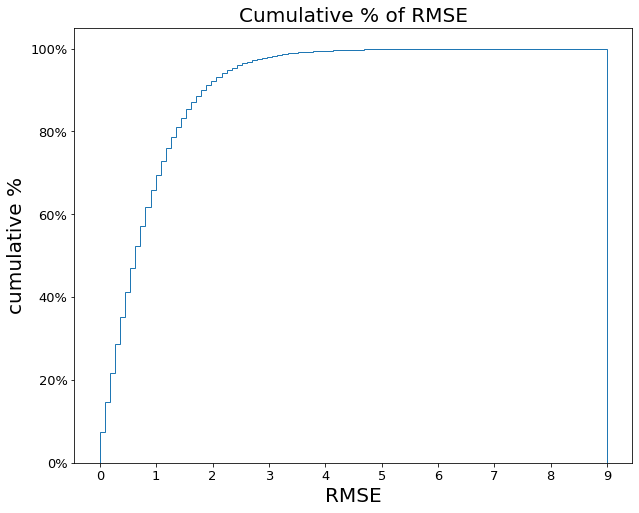

In [ ]:
#distribution of error
from matplotlib.ticker import PercentFormatter
df.err.sort_values().plot( kind = 'hist' , bins = 100 
                          ,fontsize = 13
                          ,xticks = range(0,10) ,histtype='step',
                           cumulative=True ,weights=np.ones(len(df)) / len(df) , figsize = (10,8) )

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().set_xlabel("RMSE", fontsize = 20)
plt.gca().set_ylabel( 'cumulative %', fontsize = 20)
plt.gca().set_title('Cumulative % of RMSE' , fontsize = 20)


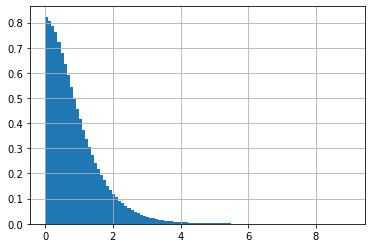

In [ ]:
df.err.sort_values().hist( bins = 100 ,density = True)
